In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [2]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)

In [3]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [4]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [5]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [6]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [7]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category1
category

,Amount
date,
2023-02-07,1138381
2023-02-08,2052035
2023-02-09,1306935
2023-02-10,645072
2023-02-11,827712
...,...
2023-11-06,1396202
2023-11-07,1441488
2023-11-08,1867192


# Remove outliers 

In [8]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(23)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [9]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

# Adding Lagged Variables

In [10]:
lags = [1,2,3]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3']
category = category[selected_columns]
category

,Amount,lag1,lag2,lag3
3,2089404,1024476.0,1471970.0,734380.0
4,1345410,2089404.0,1024476.0,1471970.0
5,596444,1345410.0,2089404.0,1024476.0
6,724950,596444.0,1345410.0,2089404.0
7,723634,724950.0,596444.0,1345410.0
8,1015907,723634.0,724950.0,596444.0
9,2816369,1015907.0,723634.0,724950.0
10,2284126,2816369.0,1015907.0,723634.0
11,925649,2284126.0,2816369.0,1015907.0
12,2634992,925649.0,2284126.0,2816369.0


# Adding Moving Average

In [11]:
# category['moving_avg'] = category[['lag1', 'lag2', 'lag3', 'lag4']].mean(axis=1).rolling(window=window_size).mean()
# category.dropna(inplace=True)
# category

# Train - Test Split

In [12]:
X = category.drop(category.columns[0], axis=1)
y = category['Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Selection

In [13]:
degree = 4
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

# Standardization

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.fit_transform(X_test_poly)

# PCA

In [15]:
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [16]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

In [17]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)

In [18]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(model2, f)
# result = model2.fit()
# print(result.summary())

In [19]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)
# Takes 3 target lags

# Evaluate Model

In [20]:
y_pred = model.predict(X_test_pca)

In [21]:
mse = mean_squared_error(y_test, y_pred)
rmse =  np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Squared Error : {mse}')
print(f'Root Mean Squared Error : {rmse}')

Mean Squared Error : 54525758158.57946
Root Mean Squared Error : 233507.5119960372


# Make Time Series Predictions

In [22]:
X_test

,lag1,lag2,lag3
19,1396202.0,486323.0,575808.0
20,1441488.0,1396202.0,486323.0
21,1867192.0,1441488.0,1396202.0
22,1401098.0,1867192.0,1441488.0


In [23]:
y_pred

array([1487849.62489432, 1563822.53749023, 1108173.26238606,
       1469237.57522939])

In [24]:
index_start = 19
index = range(index_start, index_start + len(y_pred))
df = pd.DataFrame(y_pred, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

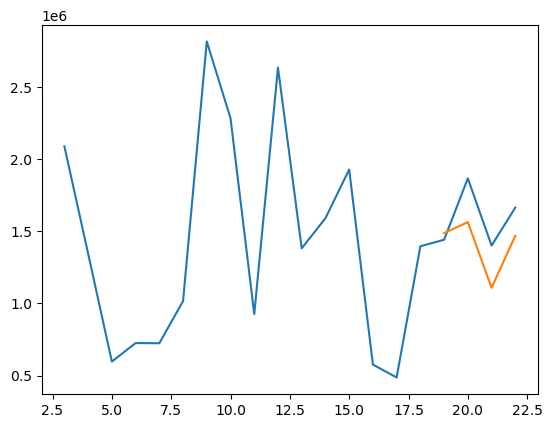

In [25]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel